## Este código es para juntar espectros

In [662]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import poisson, chi2, expon, binom
from scipy.optimize import curve_fit
from scipy.integrate import quad
import pandas as pd
import time
import random as rnd
from tqdm import tqdm
import math 
import sympy 

colors=['darkcyan','indianred','#fb8b24','#392f5a',  'palegoldenrod','olivedrab']

# Establecer un valor de epsilon personalizado
custom_epsilon = 1e-50 # Puedes ajustar este valor según tus necesidades

# Configurar el epsilon personalizado en NumPy
np.finfo(np.float64).eps = custom_epsilon


Calculemos ahora la verosimilitud

In [663]:
def calcular_likelihood(va,mu,nbins):
    likelihood = 1
    ln_likelihood = 0
    for i in range(nbins):
        prob = poisson.pmf(va[i],mu[i])
        ln_likelihood += np.log(prob)
        likelihood = likelihood*prob
    return(likelihood, ln_likelihood)

In [664]:
def exponencial(x,mu):
    return mu*np.exp(-mu*x)

1. Generando el fondo: Simular N=10000 realizaciones de una variable aleatoria
con distribución uniforme discreta entre 0 y emax=80, que represente el número de
electrones de N eventos medidos. Hacer un histograma normalizado con un número
de bines nbins a determinar por el usuario. Iniciar con nbins=20.

In [665]:
N = 10000
nbins=20
emin=0
emax=80

In [666]:
#generates background
def bkg_simul(N=10000,emin=emin,emax=emax):
    bkg = np.array([])
    for j in range(0,N):
        f = rnd.randint(emin,emax)
        bkg=np.append(bkg,f)
    return bkg

#and signal
def signal_expo_simul(M=100,lamb=0.1,emax=emax):
    signal = np.array([])
    count = 0
    while count<M:
        s = np.random.exponential(1/lamb)
        if s<emax:
            count += 1
            signal = np.append(signal,s)
    return signal

Generamos el fondo

Verosimilitud -94.29889719644507


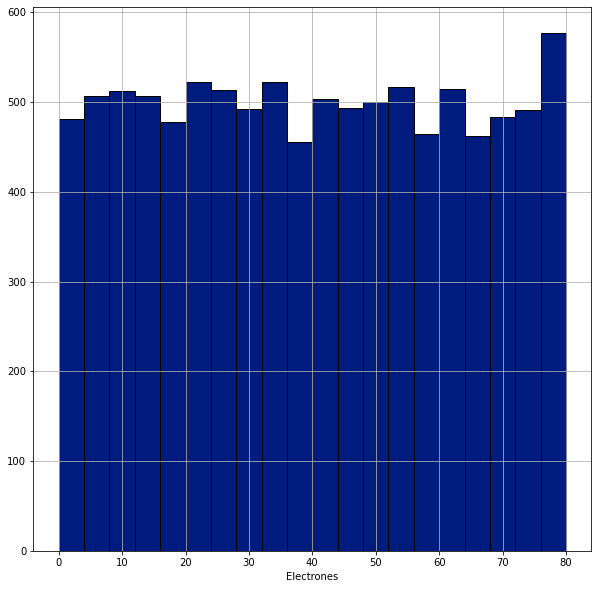

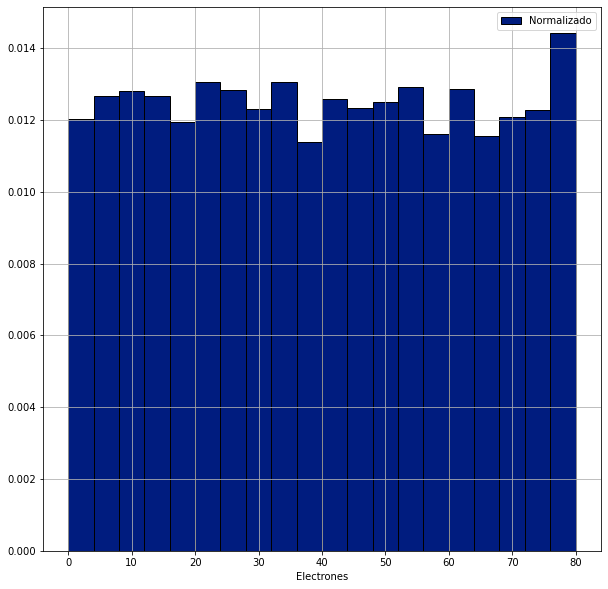

In [667]:
fondo = np.array([])
for j in range(0,N):
    F = rnd.randint(emin,emax)
    fondo=np.append(fondo,F)
    
plt.figure()
histograma_sin_normalizar = plt.hist(fondo, nbins)
plt.xlabel("Electrones")
plt.figure()
histograma = plt.hist(fondo, nbins, density=True, label='Normalizado')
plt.xlabel("Electrones")

prob_f = 1/(emax-emin)
borde_bins = histograma_sin_normalizar[1]
va_f = histograma_sin_normalizar[0]
anchos = borde_bins[1]-borde_bins[0]
mu_f= np.repeat(prob_f*anchos*N,nbins)


ln_L_f = calcular_likelihood(va_f,mu_f,nbins)[1]
print('Verosimilitud',ln_L_f)

plt.legend()
plt.show()



2. Generando la señal. En primer lugar repetir el punto anterior (no duplicar el
histograma, sino volver a generar N realizaciones de la misma variable aletoria).
Sumar a este histograma m realizaciones de una variable aleatoria con distribución
exponencial de parámetro λ. Tanto m como λ a fijar por el usuario. Iniciar con
m=100 y λ=0.1. No incluir realizaciones mayores a emax.

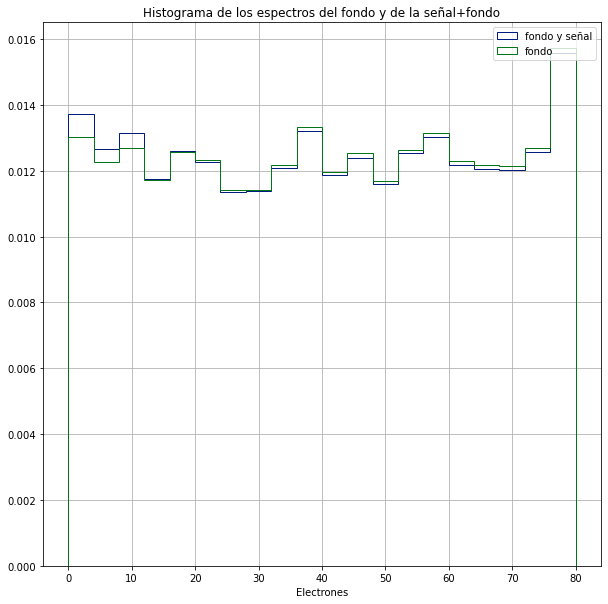

In [668]:
fondo = np.array([])
for j in range(0,N):
    F = rnd.randint(emin,emax)
    fondo=np.append(fondo,F)

    
    
señal = np.array([])
lamb = 0.1
m = 100
for i in range(m):
    S = np.random.exponential(1/lamb)
    if S<emax:
        señal = np.append(señal,S)


señalyfondo = np.concatenate((fondo,señal))
plt.figure()
plt.hist(señalyfondo, nbins, density=True, histtype="step", label='fondo y señal')
plt.hist(fondo, nbins, density=True, histtype="step", label='fondo')
#histograma_señal = plt.hist(señal, bins=np.arange(emin, emax + anchos_f, anchos_f), density=True, label='señal')
plt.xlabel("Electrones")
plt.title('Histograma de los espectros del fondo y de la señal+fondo')
plt.legend()
plt.show()

Graficamos la señal sola

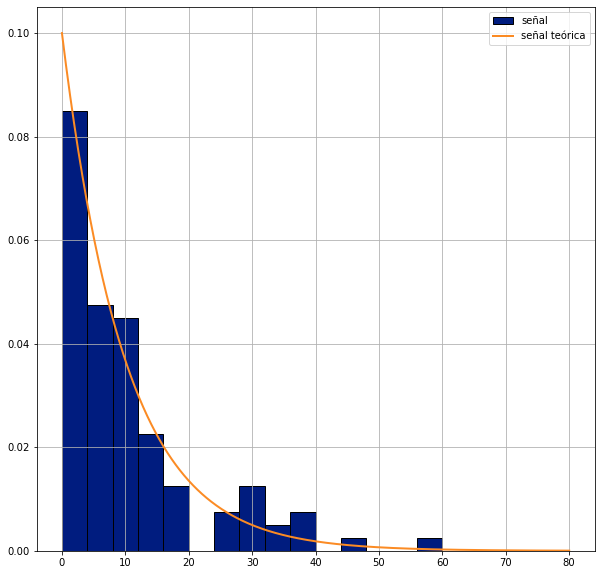

In [669]:
señal = np.array([])
lamb = 0.1
m = 100
for i in range(m):
    S = np.random.exponential(1/lamb)
    if S<emax:
        señal = np.append(señal,S)

va_syf=plt.hist(señal,bins=np.arange(emin, emax + anchos, anchos), density=True ,label='señal')[0]

puntos=np.linspace(0,80,1000)
plt.plot(puntos,exponencial(puntos,lamb), linewidth=2, color=colors[2], label='señal teórica')

plt.legend()


Integro numéricamente

In [670]:
areas_integradas = np.array([])
errores_integracion = np.array([])
for i in range(nbins):
    lower_limit = borde_bins[i]
    upper_limit = borde_bins[i+1]
    result, error = quad(exponencial, lower_limit, upper_limit, args=(lamb))
    areas_integradas = np.append(areas_integradas, result)
    errores_integracion = np.append(errores_integracion, error)

mu_s = N*areas_integradas 
ln_L_syf = calcular_likelihood(va_f,mu_s+mu_f,nbins)[1]
print('Verosimilitud',ln_L_syf)

Verosimilitud -inf


C:\Users\Zoe\AppData\Local\Temp\ipykernel_23576\1915559824.py:6: RuntimeWarning: divide by zero encountered in log
  ln_likelihood += np.log(prob)


3. λ(H0): Calcular la verosimilitud de los datos de fondo bajo la hip´otesis nula de
que provinen del fondo y la verosimilitud de los datos de fondo bajo la hip´otesis
alternativa de que provinen del fondo mas señal. A partir de ambas, calcular el
cociente de las dos cantidades anteriores m=1000 veces y hacer un histograma de
la variable aleatoria
λ =L(e|H0)/L(e|H1)


In [671]:
def log_q(mu_f,mu_syf,n):
    log_q = 0
    for i in range(len(n)):
        log_q = log_q + (mu_syf[i] - mu_f[i] + n[i]*np.log(mu_f[i]/mu_syf[i]))
    return log_q

In [672]:
#pruebo la fucnión
mu=[1,1.1,1.2]
mu2=[1.1,1.2,1.3]
n=[1,2,3]
print(log_q(mu,mu2,n))

-0.2094610568041937


In [673]:
def calcular_log_q(N, nbins, emax, emin):

    #genero fondo y señal
    fondo = np.array([])
    for j in range(0,N):
        F = rnd.randint(emin,emax)
        fondo=np.append(fondo,F)

    señal = np.array([])
    lamb = 0.1
    m = 100
    for i in range(m):
        S = np.random.exponential(1/lamb)
        if S<emax:
            señal = np.append(señal,S)
            
            
    fondo_nuevo = np.array([])
    for j in range(0,N):
        F = rnd.randint(emin,emax)
        fondo_nuevo=np.append(fondo_nuevo,F)

    señalyfondo = np.concatenate((fondo_nuevo,señal))

    histograma_f = np.histogram(fondo, nbins)
    va_f = histograma_f[0] #ni
    borde_bins = histograma_f[1]
    anchos = borde_bins[1]-borde_bins[0]

    #calculo verosimilitudes

    prob_f = 1/(emax-emin)
    mu_f= np.repeat(prob_f*anchos*N,nbins)
    ln_L_f = calcular_likelihood(va_f,mu_f,nbins)[1]
    #print('Verosimilitud dada H0',ln_L_f)

    areas_integradas = np.array([])
    errores_integracion = np.array([])
    for i in range(nbins):
        lower_limit = borde_bins[i]
        upper_limit = borde_bins[i+1]
        result, error = quad(exponencial, lower_limit, upper_limit, args=(lamb))
        areas_integradas = np.append(areas_integradas, result)
        errores_integracion = np.append(errores_integracion, error)

    histograma_syf = np.histogram(señalyfondo, nbins)
    va_syf = histograma_syf[0]

    M=100
    mu_s = M*areas_integradas
    ln_L_syf = calcular_likelihood(va_f,mu_s+mu_f,nbins)[1]
    #print('Verosimilitud dada H1',ln_L_syf)

    log_q0 = log_q(mu_f,mu_s+mu_f,va_f)
    log_q1 = log_q(mu_f,mu_s+mu_f,va_syf)
    return(log_q0,log_q1) 
    

In [674]:
log_q0=np.array([])
log_q1=np.array([])

for i in tqdm(range(1000)):
    calculo=calcular_log_q(N, nbins, emax, emin)
    log_q0=np.append(log_q0,calculo[0])
    log_q1=np.append(log_q1,calculo[1])
    

  0%|          | 1/1000 [00:00<04:20,  3.84it/s]

100%|██████████| 1000/1000 [04:14<00:00,  3.94it/s]


In [675]:
def errores(histo,rep):
    err_y=[]
    total=0
    for j in histo[0]:
        total+=j
    
    for i in histo[0]:
        p_i=i/total
        err_y.append(np.sqrt(total/rep*p_i*(1-p_i)))

    return err_y

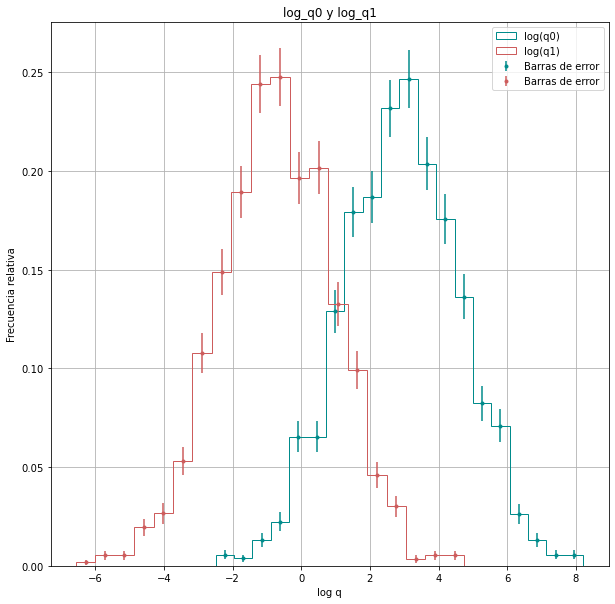

In [676]:
hist_0=plt.hist(log_q0, bins=20, density=True, label='log(q0)', color=colors[0], histtype='step')
bin_centers0 = 0.5 * (hist_0[1][1:] + hist_0[1][:-1])
ancho0=bin_centers0[1]-bin_centers0[0]
bin_errors0 = np.sqrt(hist_0[0]/ len(log_q0))
plt.errorbar(hist_0[1][:-1]+0.5*ancho0, hist_0[0], yerr=errores(hist_0,len(log_q0)), fmt='.',  label='Barras de error', color=colors[0])

hist_1=plt.hist(log_q1, bins=20, density=True, label='log(q1)', color=colors[1], histtype='step')
bin_centers1 = 0.5 * (hist_1[1][1:] + hist_1[1][:-1])
ancho1=bin_centers1[1]-bin_centers1[0]
bin_errors1 = np.sqrt(hist_1[0]/ len(log_q1))
plt.errorbar(hist_1[1][:-1]+0.5*ancho1, hist_1[0], yerr=errores(hist_1,len(log_q1)), fmt='.',  label='Barras de error', color=colors[1])

plt.xlabel('log q')
plt.ylabel('Frecuencia relativa')
plt.title('log_q0 y log_q1')
plt.legend()

Ahora con este histograma vamos a hacerle un TH:

- Establecemos una significancia de $\alpha=0.05$ a cola izquierda
- Calculamos el valor crítico $q_c$
- Calculamos $\beta$
- Y la potencia del test: $1-\beta$



In [677]:
def calcular_vc(alpha, hist):
    posicion_bins = hist[1]
    altura_bins = hist[0]
    area = 0
    i = 0
    #print(area_bins)
    while area < alpha:
        area += (posicion_bins[i+1]-posicion_bins[i])*altura_bins[i]
        vc = posicion_bins[i]
        i += 1
        #print(vc, i, area)
    return vc, area #area is my new alpha

#preguntar si sumo bien bins??
def calcular_beta(vc, hist):
    alto_bins = hist[0]
    posicion_bins = hist[1]
    i = 0
    area = 0
    while posicion_bins[i] < vc:
        area+=alto_bins[i]*(posicion_bins[i+1]-posicion_bins[i])
        i+=1
    potencia = 1 - area
    return area, potencia

## Simulo experimento con H1

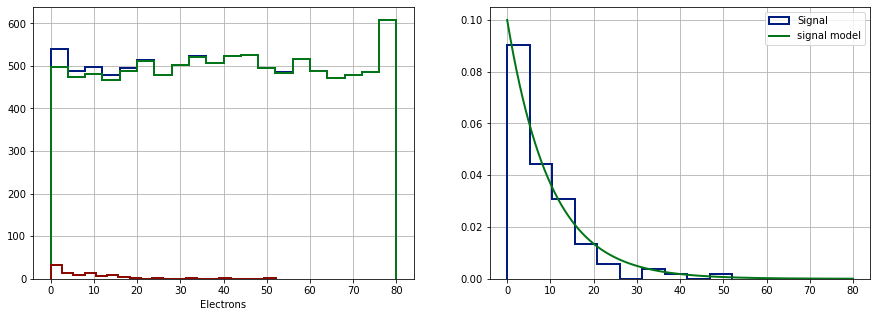

5343.421711460488


In [678]:
alpha = 0.05
nbins=20
eMin=0
eMax=80
N=10000
M=100
lamb=0.1

bkg = bkg_simul(N=N)
signal = signal_expo_simul(M=100, lamb=lamb)
total = np.concatenate((bkg,signal))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
histogram_total = plt.hist(total, nbins, histtype="step", linewidth=2, label='Background + Signal')
plt.xlabel("Electrons")
histogram = plt.hist(bkg, nbins, histtype="step", linewidth=2, label='Background')
plt.xlabel("Electrons")
plt.hist(signal, bins=nbins, histtype="step", linewidth=2, label='Signal' )


plt.subplot(1, 2, 2)
plt.hist(signal, bins=nbins-10,density=True, histtype="step", linewidth=2, label='Signal' )
xp=np.linspace(eMin,eMax,1000)
plt.plot(xp,exponencial(xp,lamb), linewidth=2, label='signal model')
plt.legend()
plt.show()


#mu_fondo
prob_bkg = 1/(eMax-eMin)
bin_size = histogram[1][1]-histogram[1][0]
mu_bkg= np.repeat(prob_bkg*bin_size*N,nbins)

#mu_señal
signal_integral = np.array([])
err_signal_integral = np.array([])
for bin in range(nbins):
    i,e = quad(exponencial, histogram[1][bin], histogram[1][bin+1], args=(lamb))
    signal_integral = np.append(signal_integral,i)
    err_signal_integral = np.append(err_signal_integral,e)
    #print(bin,edges[bin], edges[bin+1],i,e)
    
mu_histo_signal=M*signal_integral

mu_total=mu_s+mu_f

log_q_medido1 = log_q(mu_bkg, mu_total, histogram_total[0])
print(log_q_medido1)



## Simulo exp con H0

5384.789098006632


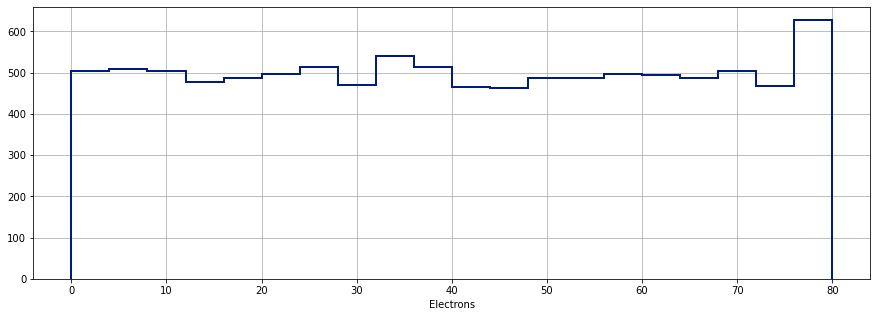

In [679]:
bkg = bkg_simul(N=N)
plt.figure(figsize=(15, 5))
histogram = plt.hist(bkg, nbins, histtype="step", linewidth=2, label='Background')
plt.xlabel("Electrons")
mu_total=mu_s+mu_f
log_q_medido0 = log_q(mu_f, mu_total, histogram[0])
print(log_q_medido0)

### Mirar acá!

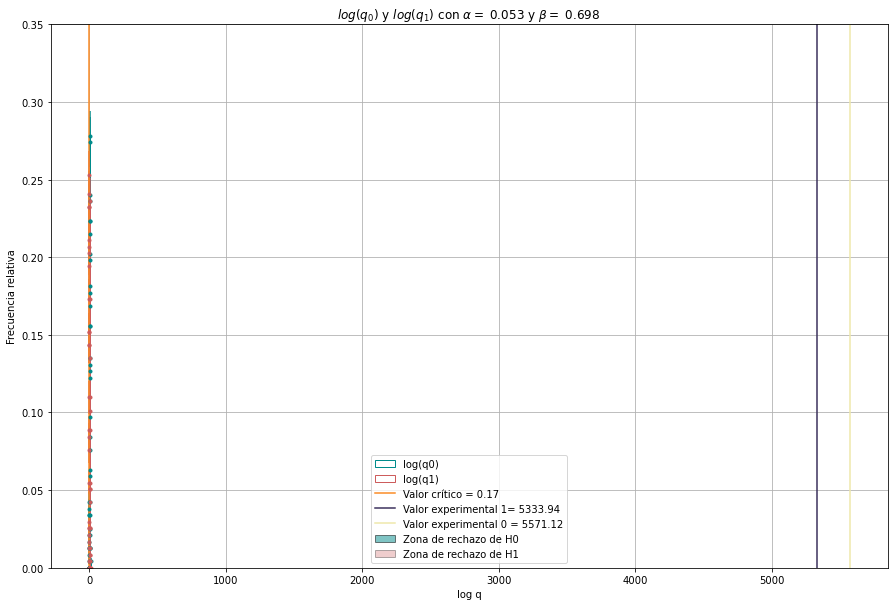

In [661]:
plt.figure(figsize=(15,10))
bines=np.linspace(-6,8,60)

hist_0=plt.hist(log_q0, bins=bines, density=True, label='log(q0)', color=colors[0], histtype='step')
bin_centers0 = 0.5 * (hist_0[1][1:] + hist_0[1][:-1])
ancho0=bin_centers0[1]-bin_centers0[0]
bin_errors0 = np.sqrt(hist_0[0]/ len(log_q0))
plt.errorbar(hist_0[1][:-1]+0.5*ancho0, hist_0[0], yerr=errores(hist_0,len(log_q0)), fmt='.',   color=colors[0])

hist_1=plt.hist(log_q1, bins=bines, density=True, label='log(q1)', color=colors[1], histtype='step')
bin_centers1 = 0.5 * (hist_1[1][1:] + hist_1[1][:-1])
ancho1=bin_centers1[1]-bin_centers1[0]
bin_errors1 = np.sqrt(hist_1[0]/ len(log_q1))
plt.errorbar(hist_1[1][:-1]+0.5*ancho1, hist_1[0], yerr=errores(hist_1,len(log_q1)), fmt='.', color=colors[1])

valor_critico=calcular_vc(alpha, hist_0)[0]
alpha_efectivo=calcular_vc(alpha, hist_0)[1]
beta, potencia=calcular_beta(valor_critico, hist_1)
plt.axvline(valor_critico, color=colors[2], label='Valor crítico = {}'.format(round(valor_critico,2)))

plt.axvline(log_q_medido1, color=colors[3], label='Valor experimental 1= {}'.format(round(log_q_medido1,2)))
plt.axvline(log_q_medido0, color=colors[4], label='Valor experimental 0 = {}'.format(round(log_q_medido0,2)))


#zona_rechazo = plt.hist(log_q0[log_q0<valor_critico], density=True , bins=9, alpha=0.3, color=colors[0])
alturas0=hist_0[0]
#plt.bar(log_q0[log_q0<valor_critico], height=alturas0, width=ancho0)

partial_heights = hist_0[0]
x_positions = hist_0[1]
#plt.bar(x_positions, partial_heights, color='red', alpha=0.7)

hist_norm = hist_0[0] / sum(hist_0[0])

# Create a bar plot for the first two bins
plt.bar(hist_0[1][:-1][:26], hist_0[0][:26], width=np.diff(hist_0[1][:27]), align='edge', color=colors[0], label='Zona de rechazo de H0', alpha=0.5)
plt.bar(hist_1[1][:-1][26:], hist_1[0][26:], width=np.diff(hist_1[1][26:]), align='edge', color=colors[1], label='Zona de rechazo de H1', alpha=0.3)


#plt.fill_betweenx([0,np.max(hist_0[0])],valor_critico,np.max(hist_0[1]), alpha=0.2)
# Use axvspan to highlight the region
#plt.axvspan(np.min(hist_1[1]), valor_critico, alpha=0.2, color=colors[1], label='Aceptación de H1')
#plt.axvspan(valor_critico, np.max(hist_0[1]), alpha=0.2, color=colors[0], label='Aceptación de H0')


plt.xlabel('log q')
plt.ylabel('Frecuencia relativa')
plt.ylim(0,0.35)
plt.title(r'$log (q_0)$ y $log(q_1)$ con $\alpha=$ {} y $\beta=$ {}'.format(round(alpha_efectivo,3), round(beta,3)))
plt.legend()



Verosimilitud con fondo: A partir de kmed,i, las alturas del histograma de fondo,
y σi su error, calcular
ki = kmed,i − nσi (2)
Dejar que n sea definido por el usuario, iniciar con n=2. Y siendo ni
las alturas del
histograma de fondo m´as se˜nal, calcular:
L(µ, |k, s) =
nbins
Y
i
(µsi + ki)
ni
ni
!
exp[−(µsi + ki)] (3)
donde µ, por ahora, es un par´ametro libre a ajustar por el usuario. Iniciar en µ = 1.